# Problema de la Mochila

A continuación se muestran los diferentes pasos de la solución al Problema de La Mochila con DEAP

## Descripcion del problema

Se puede encontrar una descripción completa del problema de la mochila en el siguiente [enlace](https://es.wikipedia.org/wiki/Problema_de_la_mochila).

In [3]:
import random
import numpy as np

import matplotlib.pyplot as plt

from deap import base, creator
from deap import tools
from deap import algorithms

C:\ProgramData\Anaconda\lib\site-packages\deap-1.2.2-py3.6.egg\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.


## Datos del problema
Por simplificación, aquí se incluyen ya los vectores que contienen los datos del problema. En muchos casos, es probable que tengamos que extraerlos de un fichero externo

In [4]:
#Trabajamos con 5 objetos
values = [10,200,50,120,200] # valor de cada objeto
weights = [45,80,25,15,75] # peso de cada objeto
knapsackMax = 200 # peso maximo que se puede cargar en la mochila

## Estructuras de datos de configuración

En primer lugar, se crea el objeto donde iremos guardando las diferentes configuraciones

In [5]:
toolbox = base.Toolbox()

## Configuración de los Individuos

Esta configuración dependerá del problema. Queda a decisión del programador la definición de cada individuo.

1. En primer lugar Se configura el fitness que se va a emplear en los individuos  
En este caso se configura para:  
    a.buscar un único objetivo: es una tupla de solo un numero  
    b.maximizar ese objetivo (se multiplica por un positivo)  
    
2. Se configura el individuo para que utilice la descripción anterior de fitness dentro de los individuos

In [6]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

1. Se configura el atributo ("attribute") con el que se generará cada gen del individuo
2. El individuo se crea como una lista (o repeticion) de "attribute", definido justo antes
3. La población se crea como una lista de "individual", definido justo antes

In [7]:
# Ejemplo de Genotipo cuyos genes son de tipo booleano '''
toolbox.register("attribute", random.randint, 0, 1)
#Tendrá una longitud de 5 atributos 
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attribute, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual) 

Se comprueba que está correctamente definido. 
No es necesario incluir esta celda en el experimento final.

In [9]:
# Se genera un único individuo
ind = toolbox.individual()
print("Individuo: ",ind)
    
# Se inicializa la poblacion. Tendrá un total de 10 individuos. 
# Se genera como una lista de individuos 
pop = toolbox.population(n=10)

# Se imprime la población: 10 individuos de 5 genes cada uno
print("Poblacion: ",pop)

Individuo:  [1, 1, 1, 1, 1]
Poblacion:  [[0, 1, 0, 0, 0], [0, 1, 0, 0, 0], [1, 1, 1, 0, 1], [1, 1, 0, 1, 1], [0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [1, 0, 1, 1, 0], [0, 0, 1, 0, 1], [0, 0, 0, 0, 1], [1, 0, 1, 0, 1]]


## Evaluación de la Adaptación

Para poder ejecutar el algoritmo genético, tendremos que implementar una función que, dado un individuo, nos indique (de manera numérica) cómo de adaptado está a la solución que estamos buscando.

In [10]:
def evalKnapsack(individual):

    value = 0.0
    weight = 0.0
    
    # Producto vectorial de un individuo (boolean) por los datos (float)
    # Multiplica cada bit del individuo por el valor correspondiente en el vector de datos
    # y finalmente hace la suma de todos
    value = np.dot(individual,values)
    weight = np.dot(individual,weights) # Mismo cáculo para el vector de pesos

#    print("value: ", value)
#    print("weight: ", weight)

    # Se penaliza en caso de que el peso de la mochila exceda el maximo
    diff = knapsackMax - weight
    if(diff < 0):
         value = value + (diff * 10) # OJO: tened en cuenta que diff es negativo, por lo que en realidad está RESTANDO

    return value, #OJO: La respuesta tiene que ser una tupla, aunque solo consideremos un valor

A continuación se incluye un apartado que comprueba que la función de evaluación definida es válida. Este código NO es necesario para la solución final, sino solo como demostración de la anterior.

In [12]:
# Se instancia un individuo (aleatorio)
ind = toolbox.individual()
 
'''
Se aconseja al alumno probar con varios individuos en diferentes condiciones
de optimalidad para comprobar si la función está bien definida en todo el 
espacio de búsqueda.    
'''

# Se imprime el individuo ANTES de evaluar
print ("\nIndividuo ANTES de evaluar")
print (ind)
print (ind.fitness.valid)  # False

ind.fitness.values = evalKnapsack(ind)

# Se imprime el individuo DESPUES de evaluar
print ("\nIndividuo TRAS evaluar")
print (ind)
print (ind.fitness.valid) # True
print (ind.fitness)


Individuo ANTES de evaluar
[1, 1, 1, 0, 0]
False

Individuo TRAS evaluar
[1, 1, 1, 0, 0]
True
(260.0,)


## Configuración de la Evolución

Ya hemos configurado todas las partes diréctamente relacionadas con el problema a resolver. A continuación vamos a configurar cómo queremos que la librería DEAP realice la evolución de los individuos que representan soluciones hasta encontrar la más adecuada.
Esta parte consiste en seleccionar que procedimientos queremos emplear en cada una de las partes del ciclo evolutivo.

In [13]:
# Se seleccionan procedimiento standard para cruce, mutacion y seleccion. Se recomienda repasar el material visto en teoría.
toolbox.register("select", tools.selTournament, tournsize=3) # seleccion
toolbox.register("mate", tools.cxOnePoint) # cruce
toolbox.register("mutate", tools.mutFlipBit, indpb=0.2) # mutacion

# Se define cómo se evaluará cada individuo
# En este caso, se hará uso de la función de evaluación que se ha definido en la sección anterior
toolbox.register("evaluate", evalKnapsack)

## Ejecución del algoritmo genético

### Configuración de las estadísticas

Si deseamos obtener algún valor para ayudarnos a comprender cómo avanza el algoritmo, debemos hacerlo en el objeto del tipo Statistics. Éste calcula resúmenes sobre la función de adaptación que contienen el conjunto de los individuos de la población.

In [14]:
# Se configura que estadísticas se quieren analizar 
stats = tools.Statistics(lambda ind: ind.fitness.values) 
stats.register("avg", np.mean) 
stats.register("std", np.std) 
stats.register("min", np.min) 
stats.register("max", np.max) 

### Llamada a la Ejecución del Algoritmo

Se ejecuta el ciclo evolutivo durante el número de generaciones determindo.
Se debe tener en cuenta que, al ser un ejemplo, el problema es muy simple y no es necesario iterar durante mucho tiempo. En los casos reales, tanto el tamaño de la población, como el número de generaciones probablemente deban ser mucho mayores.

In [17]:
# Se genera una población inicial. El tamaño será siempre de 10.
population = toolbox.population(n=10)

# Se llama al algoritmo que permite la evolucion de las soluciones
population, logbook = algorithms.eaSimple(population, toolbox, 
                                    cxpb=0.5, mutpb=0.2, # Probabilidades de cruce y mutacion
                                    ngen=20, verbose=False, stats=stats) # Numero de generaciones a completar y estadisticas a recoger

# Por cada generación, la estructura de logbook va almacenando un resumen de los
# avances del algoritmo.
print("El resultado de la evolución es: ")
print(logbook)

print("La mejor solucion encontrada es: ")
print(tools.selBest(population,1)[0])

El resultado de la evolución es: 
gen	nevals	avg	std    	min	max
0  	10    	295	109.293	60 	450
1  	8     	347	73.2189	180	450
2  	9     	334	64.6838	210	380
3  	7     	357	59.1692	180	380
4  	6     	380	0      	380	380
5  	4     	380	0      	380	380
6  	5     	323	87.4128	180	380
7  	6     	243	90.1166	180	380
8  	6     	283	97.3704	180	380
9  	4     	366	38.7814	250	380
10 	6     	360	60     	180	380
11 	5     	347	69     	170	380
12 	6     	359	59.7411	180	380
13 	7     	367	39     	250	380
14 	4     	375	15     	330	380
15 	7     	356	48     	260	380
16 	5     	380	0      	380	380
17 	3     	387	21     	380	450
18 	8     	389	107.093	210	570
19 	8     	455	93.9415	370	570
20 	6     	538	96     	250	570
La mejor solucion encontrada es: 
[0, 1, 1, 1, 1]


# Representación de los resultados
Por último, se pueden obtener gráficas empleando los datos de las estadísticas recogidas, para visualizarlos de forma más intuitiva.

[]

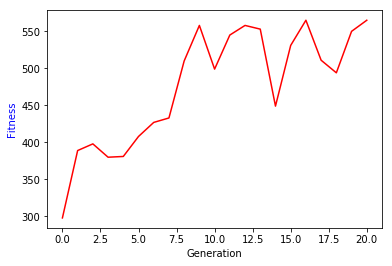

In [16]:
# Se recuperan los datos desde el log
gen = logbook.select("gen")
avgs = logbook.select("avg")
    
# Se establece una figura para dibujar
fig = plt.figure()
    
# Se representa la media del valor de fitness por cada generación
ax1 = plt.gca()
line1 = ax1.plot(gen, avgs, "r-", label="Average Fitness")    
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness", color="b")
    
''' Notad que se deberían representar mas cosas. Por ejemplo el maximo y el minimo de
ese fitness se están recogiendo en las estadisticas, aunque en el ejemplo no se
representen '''
    
plt.plot()